In [1]:
import pde
import numpy as np
import h5py

import matplotlib.pyplot as plt
from matplotlib import animation

from IPython.display import Video


barrier height 1.0000000000000002
max position 0.0
delta V 0.0


1.0000000000000002

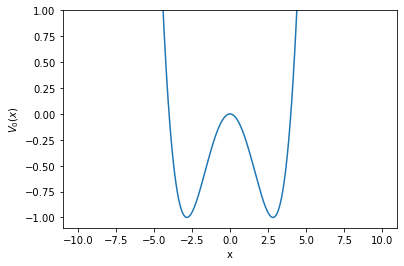

In [29]:
## POTENTIAL DEFINITION ##

## PARAMETERS

m = 1 # fixed 
w = 1 # fixed 
x_s = 2*np.sqrt(2) # local minima positions +/- , change to vary barrier length
d_c = m*w**2/(2*x_s) # critical value of d 
d = 0 # modulates maximum position and barrier height, negative values -> global minimun on the right 
# d = 0 symmetric d!=0 asymmetric

if (d <= -d_c or d >= d_c):
    # d must be lower in absolute value than the critical value
    raise ValueError()

C = m*w**2/(8*x_s**2)
x_u = d*(2*x_s**2/(m*w**2)) # maximum position
delta_V = 4*d*x_s**3/3 # between the two minima 



def V(x):
    return C*(x**2-x_s**2)**2 - d*(x**3/3-x_s**2*x)

def V0(x): # rescale potential so that Vmax is at zero
    return V(x)-V(x_u)

print('barrier height', V(x_u)-V(-x_s))
print('max position', x_u)
print('delta V', delta_V)

x = np.linspace(-10,10,1000)

plt.plot(x,V0(x))
plt.ylim(V0(x_s)*1.1, 1)
plt.xlabel('x')
plt.ylabel(r'$V_0(x)$')

V(x_u)



0.21021021021021014 -0.771343210894168
delta V -7.435686399936969e-08
barrier_height 0.5000000000000002
V(x1) -1.0000000000000002


array([-0.76296297, -0.08380526,  0.2074074 ,  0.02095131, -0.06296296,
       -0.00130946,  0.00416667])

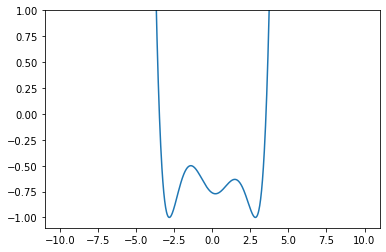

In [4]:
x1 = -2*np.sqrt(2)
x2 = -np.sqrt(2)
x4 =  1.4752617 #1.4752617 symmetric , 1.1156 asymmetric (d=-0.01)
vbar = 20
scale = 0.5 # symmetric 0.5, asymmetric (d=-0.01) 0.4277735

def V(x):
    return ((x - x2)**2*(6*vbar*(12*x**3 - 20*x*x1**2 + 9*x**2*x2 - 10*x1**2*x2 + 6*x*x2**2 + 3*x2**3 - 5*(3*x**2 - 6*x1**2 + 2*x*x2 + x2**2)*x4) + (x - x1)**2*(x1 - x2)**3*(x**2*(8*x1**2 + 9*x1*x2 + 3*x2**2 - 5*(3*x1 + x2)*x4) + 2*x*(x1*(x1 + x2)*(5*x1 + 3*x2) - (3*x1 + x2)*(5*x1 + 2*x2)*x4 + 3*(3*x1 + x2)*x4**2) + x1*(5*x1**2*(x2 - 3*x4) + 4*x2*x4*(-2*x2 + 3*x4) + 3*x1*(x2**2 - 7*x2*x4 + 8*x4**2)))))/(6*(x1 - x2)**3*(8*x1**2 + 9*x1*x2 + 3*x2**2 - 5*(3*x1 + x2)*x4))

def V_scaled(x):
    return (scale/vbar * V(x)) -scale

x = np.linspace(-10,10,1000)

plt.plot(x,V_scaled(x))
plt.ylim(V_scaled(-x1)*1.1, 1)

x_min = x[(x>x2)&(x<x4)][np.argmin(V_scaled(x)[(x>x2) & (x<x4)])]

print(x_min, V_scaled(x_min))
print('delta V', V_scaled(-x1)-V_scaled(x1))
print('barrier_height', V_scaled(x2)-V_scaled(x1))
print('V(x1)', V_scaled(x1))

pot2 = V_scaled(x)
np.polynomial.polynomial.polyfit(x, V_scaled(x), 6) 

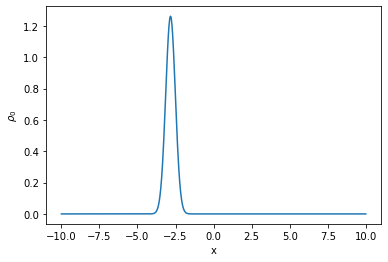

Total Probability:  1.0


In [30]:
hbar = 1                   # reduced plank constant
x0 = -x_s                 # center of initial gaussian wave-packet, start on left minima
p0 = 0                     # momentum of initial gaussian wave-packet
mu = 0.1                   # mu = <delta_(x**2)>
alpha = 0                  # alpha = <delta_x*delta_p + delta_x*delta_p>
D = hbar/(2*m)


f_name = f'FP_double_simmetric.h5'
path = './Data/Simulations/'
movie_name = f'FP_double_well_simmetric.mov'
movie_path = './Data/Movie/'

eq = pde.PDE({'rho':f'{D}*laplace(rho) + laplace(V(x))*rho + d_dx(rho)*d_dx(V(x))'}, user_funcs={'V':V})

## DEFINE SPATIAL GRID ##

Nx = 1000 # number of spatial points
x_left = -10
x_right = 10

grid = pde.CartesianGrid([(x_left,x_right)], Nx, periodic=False)

dx = grid.discretization
x = grid.cell_coords.flatten()

## DEFINE INITIAL STATE ##

# squeezed coherent Gaussian wavepacket 
rho0 = np.abs(1/((2*np.pi*mu)**0.25) * np.exp(-((1-1j*alpha)/(4*mu))*(x-x0)**2 + 1j*p0*(x-x0)/hbar))**2
initial_state = pde.ScalarField(grid=grid, data=rho0, label=r"$\rho_0$")
initial_state.plot() # TODO: ADD LABELS 

print("Total Probability: ", np.sum(initial_state.data*dx))

In [31]:
## SOLVE EQUATION ##

# define storage 
storage = pde.MemoryStorage() # for movie
file_storage = pde.FileStorage(filename=path+f_name) # dataset

# simulation time and step (1e-6 and 1e-5 seems to work, more testing needed to se if less can be used)
t_range = 100
dt_sim = 1e-5

# points to store to file
# N_t_writing = 1000 # can be changed if more points are needed
dt_writing = 0.01

# points to use in animation 
N_t_anim = 1000 # this is enough do not change it 
dt_anim = t_range/N_t_anim


solver = pde.ExplicitSolver(eq, scheme="runge-kutta", adaptive=False)
controller = pde.Controller(solver, t_range=t_range, tracker=['progress', storage.tracker(interval=dt_anim), file_storage.tracker(interval=dt_writing)])
_ = controller.run(initial_state, dt=dt_sim)



  0%|          | 0/100.0 [00:00<?, ?it/s]

In [33]:
## APPEND X DATA TO CREATED FILE ## 

file = h5py.File(path+f_name, 'a')
file.create_dataset('x', data=x)
file.close()

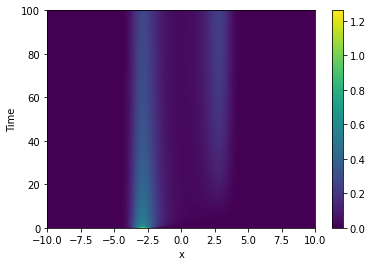

In [32]:
## PLOT SOLUTIONS ##

pde.plot_kymograph(storage)

In [12]:
from tqdm.notebook import tqdm

def my_pbar(curr_frame, tot_frame):
    pbar.update(100*curr_frame/tot_frame)

In [34]:
## GENERATE MOVIE ##

# set backend to nbagg for better movie quality, not working on deepnote
%matplotlib nbagg

simulation = storage.data
times = storage.times

fig,ax = plt.subplots()

ax.set_xlabel('x')
ax.set_ylabel('a.u.')
title = ax.set_title('', y=1.05)
line1, = ax.plot(x, V_scaled(x), "k--", label="V(x)")
line2, = ax.plot(x, np.abs(simulation[0]), "b", label=r"$\rho$")
plt.legend(loc=1, fontsize=8, fancybox=False)
plt.ylim(1.05*V_scaled(x_s), np.max(np.abs(simulation))*1.1)


def init():
    return line1, line2


def animate(i):
    ax.set_facecolor('white')
    line2.set_data(x, np.abs(simulation[i]))
    title.set_text('Time = {0:1.3f}'.format(times[i]))
    return line2


anim = animation.FuncAnimation(fig, animate, init_func=init, interval=1, blit=True, frames=np.arange(len(times)))

writer = animation.FFMpegWriter(fps=30, bitrate=-1)


print("Generating animation ...")
pbar = tqdm(total=(len(times)-1)*50) # why times 50 works?
anim.save(movie_path+movie_name, writer=writer, dpi=150, progress_callback=my_pbar)
pbar.close()
print("Done")

# reset backend to inline
%matplotlib inline

<IPython.core.display.Javascript object>

Generating animation ...


  0%|          | 0/50000 [00:00<?, ?it/s]

Done


In [35]:
## VISUALIZE MOVIE ## (not working on deepnote)

Video(movie_path+movie_name)

Probability conserved: False


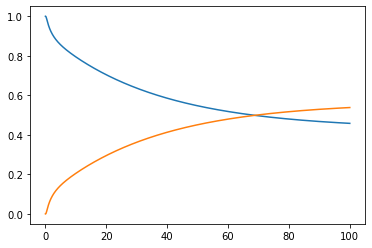

In [36]:
simulation = np.array(simulation)
# compute psi_squared
prob = np.abs(simulation)

# compute probability of finding particle on the left or right of the maximum
left_prob = prob[:, x<=x2].sum(axis=1)*dx
right_prob = prob[:, x>x2].sum(axis=1)*dx

# check if total prob is conserved
print('Probability conserved:', np.allclose(np.ones_like(left_prob), left_prob+right_prob))

plt.plot(times, left_prob)
plt.plot(times, right_prob)

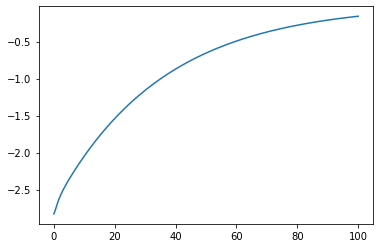

In [37]:
avg_x = np.sum(prob*x, axis=1)*dx
plt.plot(times, avg_x)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=964d390d-0269-41ab-86ee-4ee3752d1778' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

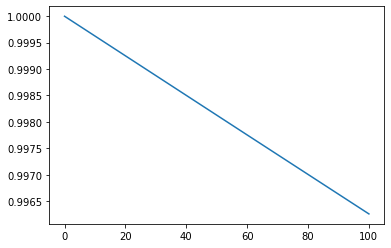

In [38]:
plt.plot(times, prob.sum(axis=1)*dx)

In [13]:
0.6/0.4

1.4999999999999998